### Restart and run all

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from sqlalchemy import create_engine
from datetime import date, timedelta
import calendar

engine = create_engine("sqlite:///c:\\ruby\\expense\\db\\development.sqlite3")
connection = engine.connect()

format_dict = {'amount':'฿{:,.2f}','max':'฿{:,.2f}','min':'฿{:,.2f}',
              'median':'฿{:,.2f}','mean':'฿{:,.2f}'}
year = 2022
today = date.today()
today

datetime.date(2023, 1, 4)

In [2]:
sql = """
SELECT * 
FROM transactions
ORDER BY id DESC
LIMIT 1"""
struct = pd.read_sql(sql, connection)
struct

,id,date,category_id,amount,created_at,updated_at
0,2459,2022-11-26,37,3500,2023-01-04 14:39:07.574909,2023-01-04 14:39:07.574909


In [3]:
struct.dtypes

id              int64
date           object
category_id     int64
amount          int64
created_at     object
updated_at     object
dtype: object

In [4]:
sql = """
SELECT strftime('%Y', date) AS year, strftime("%m", date) as month, amount, 
G.name AS kind, C.name AS item 
FROM transactions T 
JOIN categories C ON category_id = C.id 
JOIN groups G ON group_id = G.id 
WHERE strftime('%Y', date) <= '2022'
"""
#sql = sql % (year)
print(sql)


SELECT strftime('%Y', date) AS year, strftime("%m", date) as month, amount, 
G.name AS kind, C.name AS item 
FROM transactions T 
JOIN categories C ON category_id = C.id 
JOIN groups G ON group_id = G.id 
WHERE strftime('%Y', date) <= '2022'



In [5]:
df = pd.read_sql(sql, connection)
df.sample(5).style.format(format_dict)

,year,month,amount,kind,item
567,2017,05,฿190.00,Food,Food
2084,2021,12,฿70.00,Edutainment,Patreon
1740,2020,08,฿230.00,Food,Food
477,2017,02,฿90.00,Luxury,Cigarette
639,2017,07,"฿10,000.00",Parent,Parent


In [6]:
df.dtypes

year      object
month     object
amount     int64
kind      object
item      object
dtype: object

In [7]:
df['year'] = df['year'].astype('int64')
df['month'] = df['month'].astype('int64')
df['amount'] = df['amount'].astype('float')
df.dtypes

year        int64
month       int64
amount    float64
kind       object
item       object
dtype: object

### 1. What is Pandas groupby()

In [8]:
# It returns a DataFrameGroupBy object
df_groupby_year = df.groupby('year')
type(df_groupby_year)

pandas.core.groupby.generic.DataFrameGroupBy

In [9]:
# To get the number of groups
df_groupby_year.ngroups

# len(df_groupby_year)

7

In [10]:
# Stat of each group
df_groupby_year.size()

year
2016    427
2017    383
2018    352
2019    387
2020    288
2021    252
2022    332
dtype: int64

In [11]:
df_groupby_year.first().style.format(format_dict)

,month,amount,kind,item
year,,,,
2016,1,฿880.00,Food,Food
2017,1,฿160.00,Food,Food
2018,1,฿290.00,Food,Food
2019,1,฿560.00,Food,Food
2020,1,"฿2,400.00",Food,Food
2021,1,"฿4,940.00",Medicine,Medicine
2022,1,"฿2,430.00",Food,Food


In [12]:
df_groupby_year.last().style.format(format_dict)

,month,amount,kind,item
year,,,,
2016,11,"฿10,000.00",Shelter,Family
2017,12,"฿6,770.00",Food,Food
2018,12,"฿6,770.00",Food,Food
2019,12,฿320.00,Communication,Telephone Dtac
2020,12,฿170.00,Edutainment,Apple
2021,11,"฿3,300.00",Edutainment,Yearly Pluralsight
2022,11,"฿3,500.00",Edutainment,Yearly Pluralsight


In [13]:
type(df_groupby_year)

pandas.core.groupby.generic.DataFrameGroupBy

### 2. The “group by” process: split-apply-combine
Generally speaking, “group by” is referring to a process involving one or more of the following steps:

    - Splitting the data into groups
    - Applying a function to each group independently
    - Combining the results into a data structure.

#### With column

In [14]:
df.groupby('year').amount.max()

year
2016     40000.0
2017     19600.0
2018     37540.0
2019     54600.0
2020     24300.0
2021    100000.0
2022     30000.0
Name: amount, dtype: float64

In [15]:
df.groupby('year').amount.count()

year
2016    427
2017    383
2018    352
2019    387
2020    288
2021    252
2022    332
Name: amount, dtype: int64

### With agg()
    - With multiple aggregation functions
    - Custom column name
    - Custom aggregator

In [16]:
# there is a function called .agg() and it allows us to specify multiple aggregation functions at once
df.groupby('year').amount.agg(['max', 'min', 'count', 'median', 'mean']).style.format(format_dict)

,max,min,count,median,mean
year,,,,,
2016,"฿40,000.00",฿40.00,427,฿300.00,"฿1,755.97"
2017,"฿19,600.00",฿20.00,383,฿280.00,"฿1,363.81"
2018,"฿37,540.00",฿20.00,352,฿320.00,"฿1,481.59"
2019,"฿54,600.00",฿40.00,387,฿300.00,"฿2,011.87"
2020,"฿24,300.00",฿20.00,288,฿390.00,"฿2,198.65"
2021,"฿100,000.00",฿0.00,252,฿575.00,"฿2,633.49"
2022,"฿30,000.00","฿-11,500.00",332,฿420.00,"฿1,934.62"


### Without column

In [17]:
# Turns out when writting a groupby you don't actually have to specify a column like beer_servings. Without a column, 
# it will perform the aggregation across all of the numeric columns 
df.groupby('year').sum().style.format(format_dict)

,month,amount
year,,
2016,2793,"฿749,800.00"
2017,2481,"฿522,340.00"
2018,2176,"฿521,520.00"
2019,2701,"฿778,595.00"
2020,1754,"฿633,210.00"
2021,1622,"฿663,640.00"
2022,1893,"฿642,295.00"


In [18]:
# Creating a subset
subset = df.loc[:, ['year', 'month', 'amount']]

In [19]:
# Grouping by multiple categories
subset.groupby(['year', 'month']).sum().style.format(format_dict)

In [20]:
# Group by multi column
df_groupby_multi = subset.groupby(['year', 'month']).sum()
df_groupby_multi.reset_index().style.format(format_dict)

,year,month,amount
0,2016,1,"฿102,370.00"
1,2016,2,"฿42,890.00"
2,2016,3,"฿23,480.00"
3,2016,4,"฿54,090.00"
4,2016,5,"฿57,290.00"
5,2016,6,"฿72,490.00"
6,2016,7,"฿59,730.00"
7,2016,8,"฿39,570.00"
8,2016,9,"฿35,880.00"
9,2016,10,"฿104,610.00"


In [21]:
# A better way is to set as_index=False
subset.groupby(['year', 'month'], as_index=False).sum().style.format(format_dict)

,year,month,amount
0,2016,1,"฿102,370.00"
1,2016,2,"฿42,890.00"
2,2016,3,"฿23,480.00"
3,2016,4,"฿54,090.00"
4,2016,5,"฿57,290.00"
5,2016,6,"฿72,490.00"
6,2016,7,"฿59,730.00"
7,2016,8,"฿39,570.00"
8,2016,9,"฿35,880.00"
9,2016,10,"฿104,610.00"


<AxesSubplot:xlabel='year'>

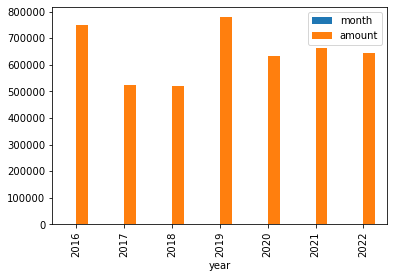

In [22]:
subset.groupby('year').sum().plot(kind='bar')

### Selected year process

In [23]:
# To retrieve one of the created groups
df_cur_yr = df_groupby_year.get_group(2022)
df_cur_yr.head().style.format(format_dict)

,year,month,amount,kind,item
2089,2022,1,"฿2,430.00",Food,Food
2090,2022,1,฿780.00,Pets,Pets
2091,2022,1,"฿1,330.00",Medicine,Medicine
2092,2022,1,฿200.00,Transportation,Transportation
2093,2022,1,"฿2,020.00",Parent,Parent


In [24]:
output = df_cur_yr.groupby(['month']).amount.sum()
output

month
1     62710.0
2     27160.0
3     97220.0
4     71150.0
5     56640.0
6     72560.0
7     26960.0
8     53940.0
9     35345.0
10    71130.0
11    37950.0
12    29530.0
Name: amount, dtype: float64

In [25]:
data_path = "../data/"
file_name = 'tmp-file-of-expenses.csv'
data_file = data_path + file_name
output.to_csv(data_file, index=True)

In [26]:
df_cur_yr.groupby('kind').amount.sum()

kind
Apparel             4010.0
Communication      34320.0
Edutainment        29380.0
Food               41845.0
Luxury              3000.0
Medicine           36150.0
Movies               950.0
Others             72600.0
Parent            201410.0
Pets              115740.0
Shelter            85100.0
Transportation     17790.0
Name: amount, dtype: float64

In [27]:
df_cur_yr.groupby('item').amount.sum()

item
Apple                   1940.0
Books & Software       10890.0
CCF                     3000.0
Food                   41845.0
Fuel                   15280.0
Funeral                48000.0
Google                  2040.0
Internet Home           7680.0
Medicine               36150.0
Merit Making           24200.0
Miscellaneous            400.0
Monthly Prime            950.0
Mother                 74390.0
Netflix                 2940.0
Packt                   3060.0
Parent                127020.0
Patreon                  560.0
Personal Care           4010.0
Pets                  115740.0
Plum                   12900.0
Shelter                72200.0
Telephone Dtac          3840.0
Transportation          1990.0
True Visions           22800.0
Vehicle                  520.0
Yearly Dropbox          4450.0
Yearly Pluralsight      3500.0
Name: amount, dtype: float64

### End of New way of writing

In [28]:
df_cur_yr.groupby('month').amount.sum()

month
1     62710.0
2     27160.0
3     97220.0
4     71150.0
5     56640.0
6     72560.0
7     26960.0
8     53940.0
9     35345.0
10    71130.0
11    37950.0
12    29530.0
Name: amount, dtype: float64

In [29]:
df_cur_yr.amount.sum()

642295.0